In [45]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from tqdm import trange
%matplotlib inline

# Load data

In [2]:
ngram=1

_dfx = pd.read_csv('BOW-datasets/BOW_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
_dfy = pd.read_csv('BOW-datasets/BOW_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)
# _dfx = pd.read_csv('BOW-datasets/Tfidf_{}-gram_data.csv'.format(ngram), header=0, index_col=0)
# _dfy = pd.read_csv('BOW-datasets/Tfidf_{}-gram_labels.csv'.format(ngram), header=0, index_col=0)

X = _dfx.values
y = _dfy.values
feat_names = _dfx.columns
print(X.shape)

(57612, 17)


# Evaluate Lasso path

In [3]:
# Evaluate the Lasso-path
nC = 10
coefs = np.empty((X.shape[1], nC))
C_range = np.logspace(-5, 0, nC)
for i in trange(nC):
    coefs[:, i] = LogisticRegression(penalty='l1', C=C_range[i]).fit(X, y.ravel()).coef_

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


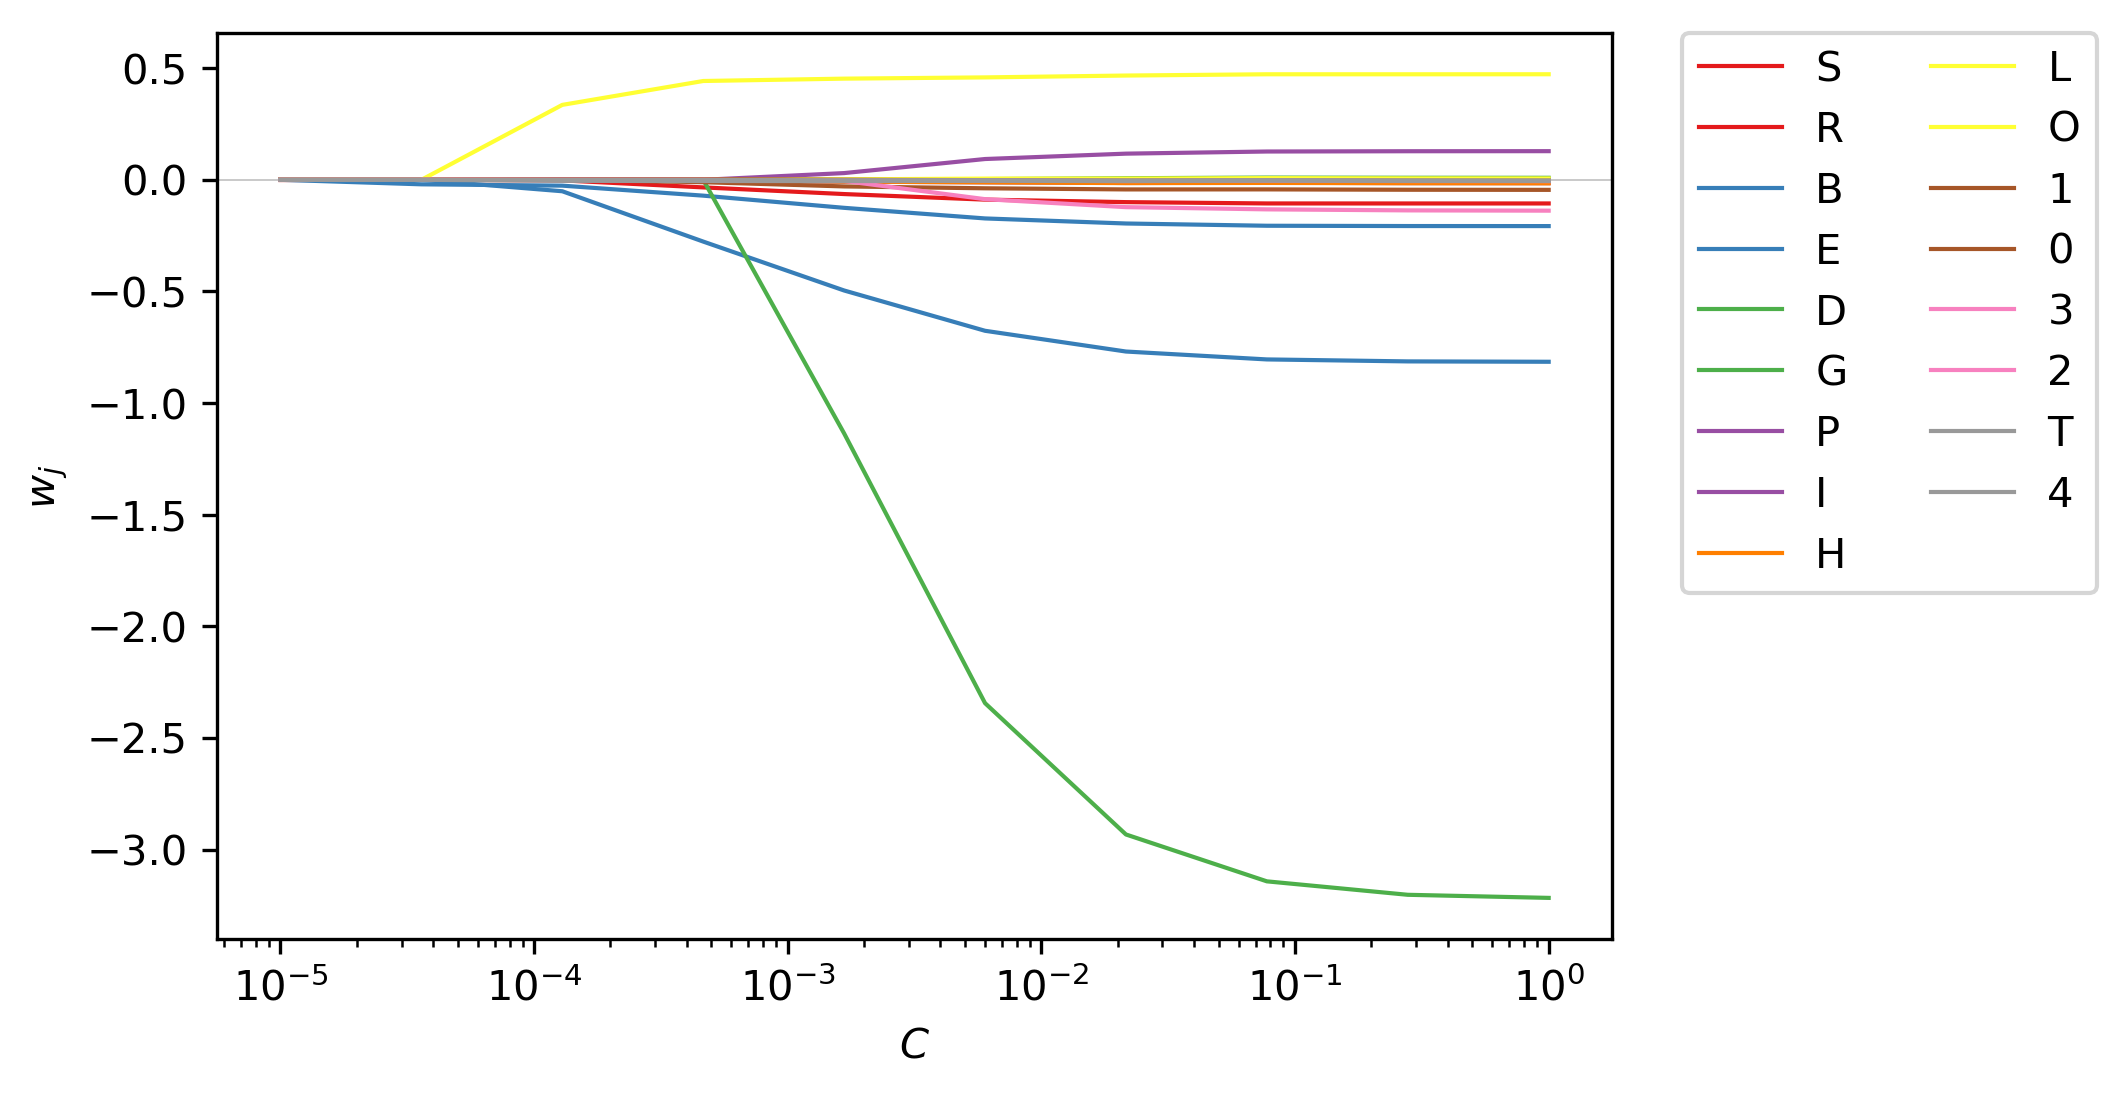

In [8]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)

colormap = plt.cm.Set1
ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, coefs.shape[0])])
plt.axhline(color='k', linewidth=.1, linestyle='solid') # xaxis

for _coef, _feature in zip(coefs, _dfx.columns):
    ax.semilogx(C_range, _coef, '-', label=_feature.upper(), linewidth=1)
    
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2)
plt.xlabel(r'$C$')
plt.ylabel(r'$w_j$');

Check which coefs detach from 0 first.

In [10]:
# features = _dfx.columns
# nonzero = []
# for c in coefs.T:
#     nonzero_id = np.where(c.ravel() != 0)[0]
#     for f in features[nonzero_id]:
#         if f not in nonzero:
#             nonzero.append(f)

# for i, n in enumerate(nonzero):
#     print('{}) {}'.format(i+1, n.upper()))

# Coefficients

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)
tr_idx, ts_idx = next(sss.split(X, y))

x_train, y_train = X[tr_idx, :], y[tr_idx].ravel()
x_test, y_test = X[ts_idx, :], y[ts_idx].ravel()

lr = LogisticRegression()
lr.fit(x_train, y_train)

print('AUC: {:2.3f}'.format(metrics.roc_auc_score(lr.predict(x_test), y_test)))
print('Acc: {:2.3f}'.format(metrics.accuracy_score(lr.predict(x_test), y_test)))
print('Prec: {:2.3f}'.format(metrics.precision_score(lr.predict(x_test), y_test)))
print('Rcll: {:2.3f}'.format(metrics.recall_score(lr.predict(x_test), y_test)))

AUC: 0.898
Acc: 0.895
Prec: 0.854
Rcll: 0.930


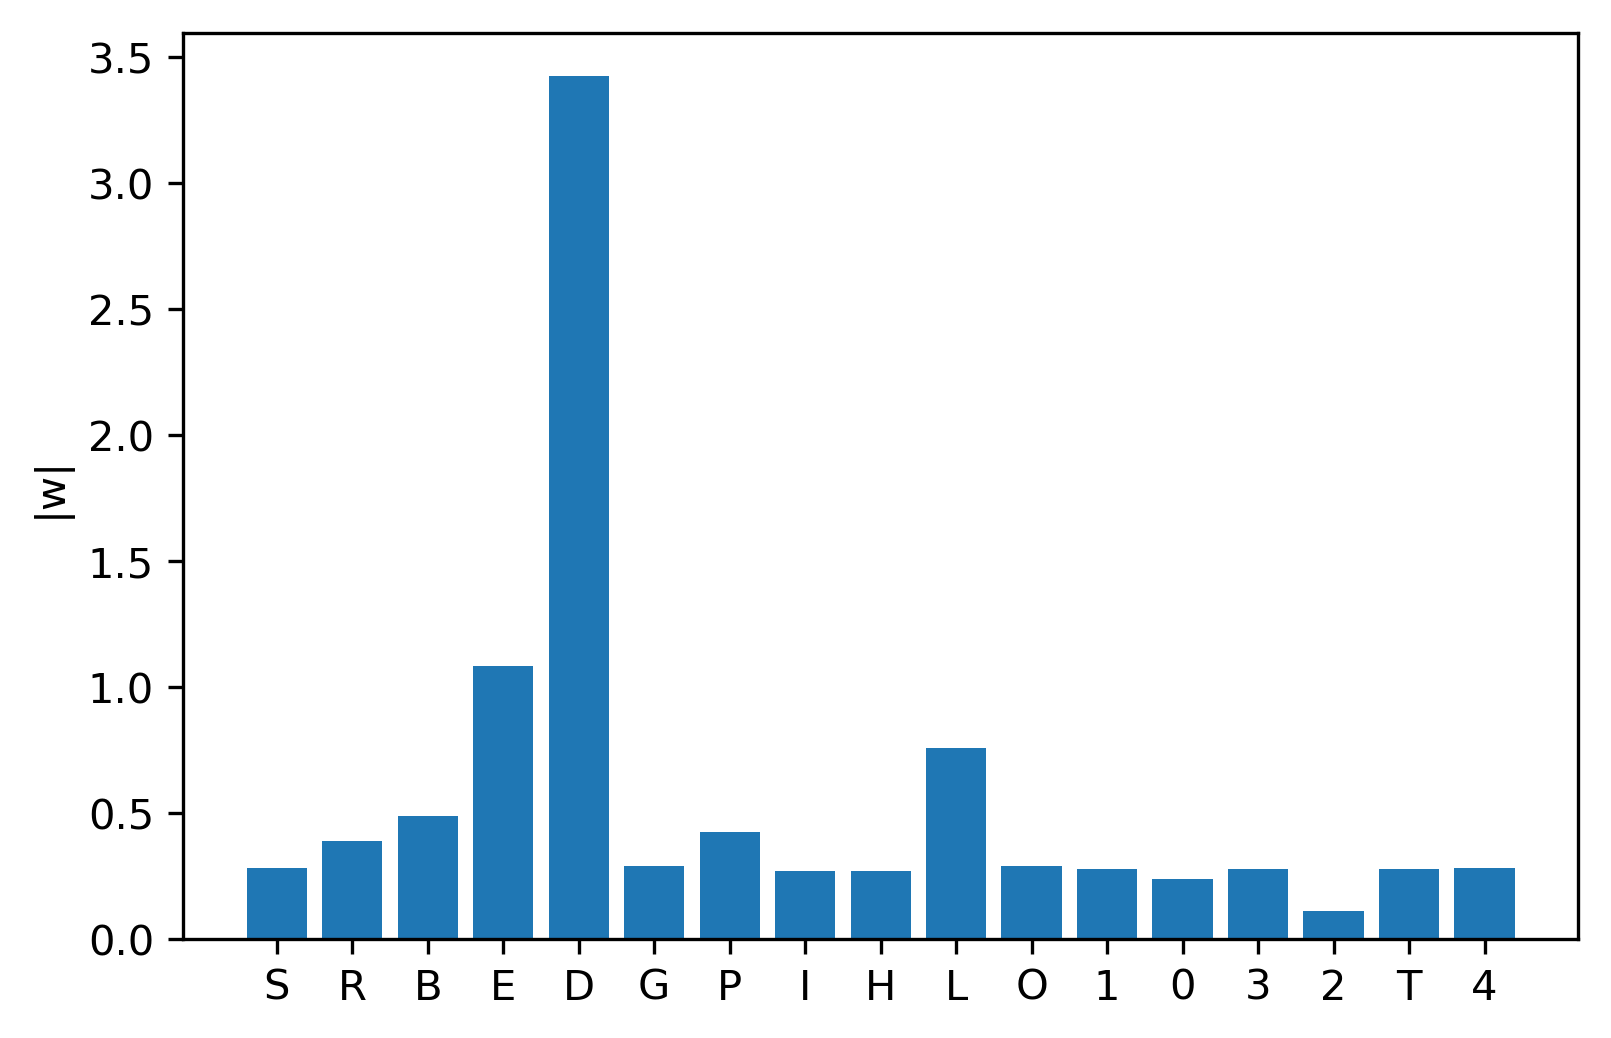

In [76]:
plt.figure(dpi=300)
plt.bar(range(x_train.shape[1]), np.abs(lr.coef_.ravel()))
plt.xticks(range(x_train.shape[1]), [s.upper() for s in _dfx.columns])
plt.ylabel('|w|');

In [70]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score

def plot_learning_curve(train_sizes, train_scores, test_scores,
                        title='title', ylabel='score', dpi=200):
    """Generate a simple plot of the test and training learning curve."""
    plt.figure(dpi=dpi)
    plt.title(title)
    plt.xlabel("# Training examples")
    plt.ylabel(ylabel)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="orange")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="royalblue")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="orange",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="royalblue",
             label="Cross-validation error")

    plt.legend(loc="best")
    return plt

def roc_auc_scorer(estimator, X, y):
    return roc_auc_score(y, estimator.predict_proba(X)[:,1])

In [73]:
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(), x_train, y_train, cv=StratifiedShuffleSplit(n_splits=5, test_size=0.25),
    n_jobs=-1, train_sizes=np.linspace(0.005, 0.5, 10),
    scoring=roc_auc_scorer)

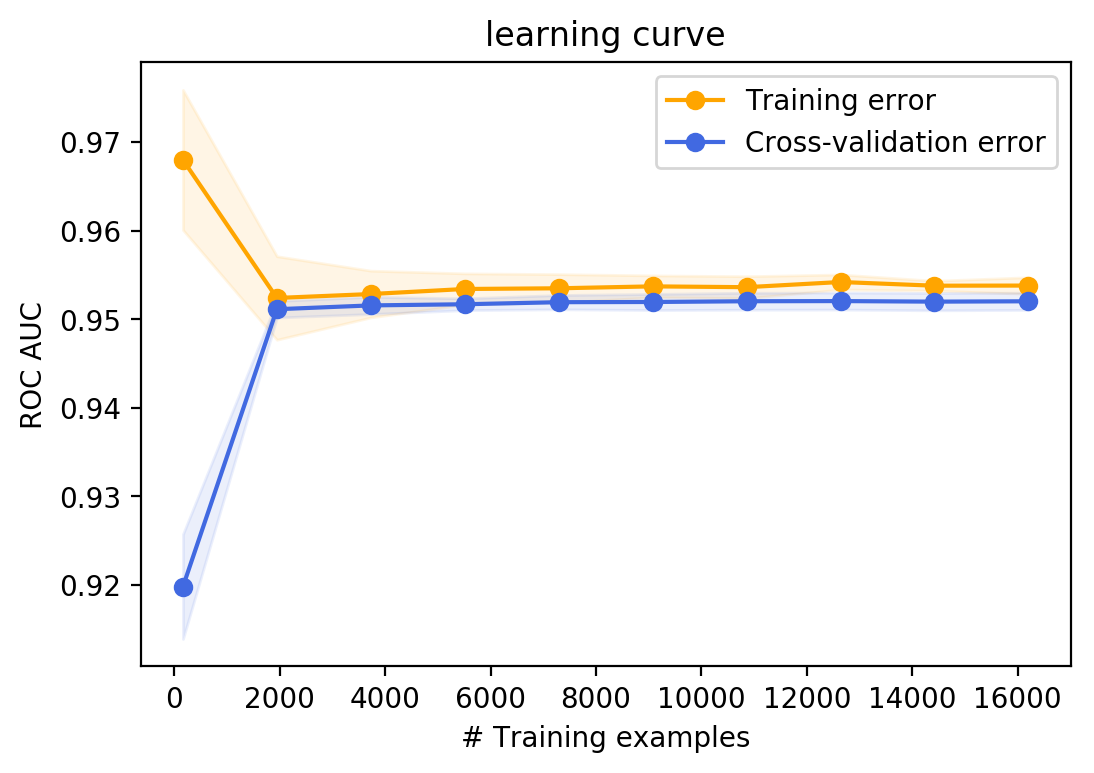

In [74]:
plot_learning_curve(train_sizes, train_scores, test_scores, title='learning curve', ylabel='ROC AUC');

In [75]:
train_sizes

array([  162,  1944,  3726,  5509,  7291,  9073, 10856, 12638, 14420,
       16203])